In [1]:
from typing import Optional, Union, Iterable, List, Dict

from functools import reduce
from operator import add

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sbn

from tqdm.notebook import tqdm
from IPython.display import display

import utils.common_utils as cu
import utils.basic_utils as bu
import utils.funcs as fn
import utils.denoising_utils as du
import utils.inpainting_utils as iu
import utils.sr_utils as su
import utils.model_utils as mu
import utils.metric_utils as metu
from utils.paths import ROOT
from utils.keywords import *
from utils.common_types import *

In [2]:
def benchmark_folder(img_stem: str, sigma=None, p=None, zoom=None):
    
    process = bu.get_process(sigma, p, zoom)
    
    folder = ROOT[BENCHMARK][process]
    if process == DENOISING:
        folder = folder[sigma]
    elif process == INPAINTING:
        folder = folder[p]
    if process == SR:
        folder = folder[zoom]
    folder = folder[img_stem]
    
    return folder

In [3]:
def read_benchmark_results(
    img_stem: str,
    metric: str,
    sigma=None, p=None, zoom=None
) -> DataFrame:
    

    df_low = ROOT[BENCHMARK][LOWPASS_METRICS_CSV].load()
    
    folder = benchmark_folder(img_stem, sigma, p, zoom)
        
    df = folder[SIMILARITY_METRICS_NOISY_IMG_CSV].load()
    
    df['psd 99_per_bw'] = df_low['psd 99_per_bw']
    
    df = df[['best psnr smooth', metric]]
        
    return df

def read_model_outputs(
    img_stem: str,
    output: Literal['last', 'best'] = 'last',
    sigma=None, p=None, zoom=None
) -> Dict[str, NumpyArray]:
    
    folder = benchmark_folder(img_stem, sigma, p, zoom)
    folder = folder[DATA]
    
    model_names = folder.physical_children()
    model_names = list(filter(lambda e: e[0] == '0', model_names))
    
    model_outputs = {}
    for name in model_names:
        htr = folder[name][HTR_PKL].load()
        out = htr[f'{output}_out_sm']
        model_outputs[name] = out
        
    return model_outputs

In [4]:
def extract_output_from_htr(
    img_stem: str,
    output: Literal['last', 'best'] = 'best',
    sigma=None, p=None, zoom=None
) -> Dict[str, Dict[str, NumpyArray]]:
    
    folder = benchmark_folder(img_stem, sigma, p, zoom)
    folder = folder[DATA]
    
    model_names = folder.physical_children()
    model_names = list(filter(lambda e: e[0] == '0', model_names))
    
    for name in tqdm(model_names):
        
        key = f'{output}_out_sm'
        fname = f'{key}.png'
        
        if not folder[name][fname].exists():
            htr = folder[name][HTR_PKL].load()
            out = htr[key]
            folder[name][fname].save(out)

In [8]:
def histogram(
    df: DataFrame, 
    mark_psnr: Optional[Union[float, List[float]]] = None, 
    add_to_samples: bool = False,
    mark_color: List[str] = 'red',
    num_bins: int = 10,
    ax: Optional[plt.Axes] = None,
    color: str = None,
    alpha: float = None,
    lw: float = None,
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    xticks: Optional[List[float]] = None,
    yticks: Iterable[float] = tuple(),
    xticks_fmt: str = '%.1f',
    yticks_fmt: Optional[str] = None
) -> None:
    ''''''
    
    from bisect import bisect_left
    from matplotlib.ticker import FormatStrFormatter
    
    columns = df.columns
    column, = columns
    
    data = list(df[column])
    if add_to_samples:
        data.append(mark_psnr)
        
    nums, bins, patches = ax.hist(data, bins=num_bins, color=color, lw=lw, alpha=alpha)
    
    if title is not None:
        ax.set_title(title, fontsize=15)
    
    if xticks is None:
        max_psnr = df[column].max()
        min_psnr = df[column].min()
        xticks = np.linspace(min_psnr, max_psnr, 5)
    ax.set_xticks(xticks)
    
    # if yticks is None:
    #     yticks = []
    ax.set_yticks(yticks)
    
    ax.xaxis.set_major_formatter(FormatStrFormatter(xticks_fmt))
    
    if yticks_fmt is not None:
        ax.yaxis.set_major_formatter(FormatStrFormatter(yticks_fmt))
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
    if isinstance(mark_psnr, float):
        mark_psnr = [mark_psnr]
    
    if isinstance(mark_color, str):
        mark_color = [mark_color]

    if mark_psnr is not None:
        for i in range(len(mark_psnr)):
            value = mark_psnr[i]
            bin_index = bisect_left(bins, value)
            patches[bin_index].set_facecolor(mark_color[i])

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

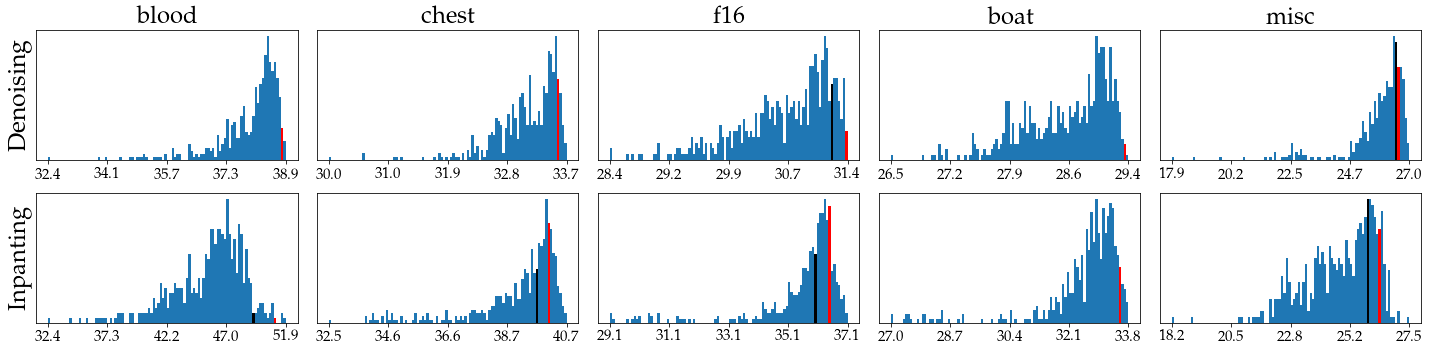

In [22]:
IMAGES = [
    'blood_512',
    'chest_512',
    'f16_512',
    'boat_512',
    '8_512',
]

metric_denoising = 'psd db strip mse'
metric_inpainting = 'psd db strip mse'

sigma = 25
p = 50

N = 15

fontsize = 24
num_bins = 100

fig, axes = plt.subplots(2, 5)

fig.set_size_inches(20, 5)
fig.set_facecolor('white')

# denoisings
for i, stem in enumerate(IMAGES):
    
    axs = axes[0]
    
    # clean title
    title = stem.split('_')[0]
    if title == '8':
        title = 'misc'
    elif title == '4':
        title = 'palace'
    # title = title[0].upper() + title[1:]
    
    # read results    
    df = read_benchmark_results(stem, metric_denoising, sigma=sigma)
    
    # draw histogram
    Ns = [5, 15]
    mark_colors = ['black', 'red']
    mark_psnrs = []
    for N, mark_color in zip(Ns, mark_colors):
        tmp = df.sort_values(by=metric_denoising, ascending=True)
        best_models: DataFrame = tmp.iloc[:N]
        best_model = best_models.idxmax()['best psnr smooth']
        mark_psnr = df.loc[best_model]['best psnr smooth']
        
        mark_psnrs.append(mark_psnr)
        
    histogram(
        df[['best psnr smooth']],
        mark_psnr=mark_psnrs,
        mark_color=mark_colors,
        num_bins=num_bins,
        ax=axs[i],
        title=title,
    )
    
    if i == 0:
        axs[i].set_ylabel('Denoising', fontsize=25)
    
    axs[i].title.set_fontsize(fontsize)
    axs[i].tick_params(axis='x', labelsize=15)
    

# inpainting
for i, stem in enumerate(IMAGES):   
    
    axs = axes[1]
     
    # read results    
    df = read_benchmark_results(stem, metric_inpainting, p=p)
    
    # draw histogram
    Ns = [5, 15]
    mark_colors = ['black', 'red']
    mark_psnrs = []
    for N, mark_color in zip(Ns, mark_colors):
        tmp = df.sort_values(by=metric_inpainting, ascending=True)
        best_models: DataFrame = tmp.iloc[:N]
        best_model = best_models.idxmax()['best psnr smooth']
        mark_psnr = df.loc[best_model]['best psnr smooth']
        
        mark_psnrs.append(mark_psnr)
        
    histogram(
        df[['best psnr smooth']],
        mark_psnr=mark_psnrs,
        mark_color=mark_colors,
        num_bins=num_bins,
        ax=axs[i]
    )
    
    if i == 0:
        axs[i].set_ylabel('Inpanting', fontsize=fontsize)
    
    axs[i].tick_params(axis='x', labelsize=15)
    
plt.tight_layout()

In [ ]:
metric = 'psd db strip mse'

sigma = 25
p = None
zoom = None
process = bu.get_process(sigma, p, zoom)

N = 15

num_bins = 100


print(metric)
fig, axs = plt.subplots(2, 5, squeeze=True, gridspec_kw={'wspace':0.03, 'hspace':0.31})
axs: List[plt.Axes] = axs.reshape((-1,))

fig.set_size_inches(20, 5)
fig.set_facecolor('white')

for i, stem in enumerate(tqdm(BENCHMARK_IMAGES)):
    
    title = stem.split('_')[0]
    if title == '8':
        title = 'misc'
    elif title == '4':
        title = 'palace'
    

    df = read_benchmark_results(stem, metric, sigma, p, zoom)
    
    Ns = [5, 15]
    mark_colors = ['black', 'red']
    mark_psnrs = []
    for N, mark_color in zip(Ns, mark_colors):
        tmp = df.sort_values(by=metric, ascending=True)
        best_models: DataFrame = tmp.iloc[:N]
        best_model = best_models.idxmax()['best psnr smooth']
        mark_psnr = df.loc[best_model]['best psnr smooth']
        
        mark_psnrs.append(mark_psnr)
        
    histogram(
        df[['best psnr smooth']],
        mark_psnr=mark_psnrs,
        mark_color=mark_colors,
        num_bins=num_bins,
        ax=axs[i],
        title=title,
    )
    

# plt.savefig(
#     'inpainting-search-space-histogram-red-best.jpeg',
#     dpi=200
# )

# plt.suptitle(metric)
# plt.tight_layout()

# fig.savefig(
#     f'data/{process}-{metric}-histogram.jpeg',
#     dpi=200, bbox_inches='tight'
# )

In [ ]:
metric = 'psd db strip mse'

sigma = None
p = 50
zoom = None
process = bu.get_process(sigma, p, zoom)

N = 15

num_bins = 100


print(metric)
fig, axs = plt.subplots(2, 5, squeeze=True, gridspec_kw={'wspace':0.03, 'hspace':0.31})
axs: List[plt.Axes] = axs.reshape((-1,))

fig.set_size_inches(20, 5)
fig.set_facecolor('white')

for i, stem in enumerate(tqdm(BENCHMARK_IMAGES)):
    
    title = stem.split('_')[0]
    if title == '8':
        title = 'misc'
    elif title == '4':
        title = 'palace'
    

    df = read_benchmark_results(stem, metric, sigma, p, zoom)
    
    Ns = [5, 15]
    mark_colors = ['black', 'red']
    mark_psnrs = []
    for N, mark_color in zip(Ns, mark_colors):
        tmp = df.sort_values(by=metric, ascending=True)
        best_models: DataFrame = tmp.iloc[:N]
        best_model = best_models.idxmax()['best psnr smooth']
        mark_psnr = df.loc[best_model]['best psnr smooth']
        
        mark_psnrs.append(mark_psnr)
    
    histogram(
        df[['best psnr smooth']],
        mark_psnr=mark_psnrs,
        mark_color=mark_colors,
        num_bins=num_bins,
        ax=axs[i],
        title=title,
    )
    

# plt.savefig(
#     'inpainting-search-space-histogram-red-best.jpeg',
#     dpi=200
# )

# plt.suptitle(metric)
# plt.tight_layout()

fig.savefig(
    f'data/{process}-{metric}-histogram.jpeg',
    dpi=200, bbox_inches='tight'
)

In [ ]:
from bisect import bisect_left
from matplotlib.ticker import FormatStrFormatter

num_bins = 100
num_marked = 1

# fig = plt.figure(figsize=(20, 6))
fig, axs = plt.subplots(2, 5, squeeze=True, gridspec_kw={'wspace':0.03, 'hspace':0.31})
axs: List[plt.Axes] = axs.reshape((-1,))

fig.set_size_inches(20, 5)
fig.set_facecolor('white')

for i, stem in enumerate(BENCHMARK_IMAGES):
    
    title = stem.split('_')[0]
    if title == '8':
        title = 'misc'
    elif title == '4':
        title = 'palace'
    

    df = dfs[stem][['best psnr smooth', metric]]
    max_psnr = df['best psnr smooth'].max()
    min_psnr = df['best psnr smooth'].min()
    
    nums, bins, patches = axs[i].hist(df['best psnr smooth'], bins=num_bins)
    
    axs[i].set_title(title, fontsize=15)
    axs[i].set_xticks(np.linspace(min_psnr, max_psnr, 5))
    axs[i].set_yticks([])
    axs[i].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # axs[i].set_xlabel('PSNR')
    
    df = df.sort_values(by=metric)
    df = df.iloc[:N]
    df = df.sort_values(by='best psnr smooth', ascending=False)
    model_names = df.index
    
    for name in model_names[:num_marked]:
        value = df.loc[name]['best psnr smooth']
        bin_index = bisect_left(bins, value)
        
        patches[bin_index].set_facecolor('red')

# plt.savefig(
#     'inpainting-search-space-histogram-red-best.jpeg',
#     dpi=200
# )

# plt.suptitle(metric)
# plt.tight_layout()

print(metric)
plt.savefig(
    f'{process}-{N=}-{metric}-histogram.jpeg',
    dpi=200, bbox_inches='tight'
)